# Сравнение тарифов сотового оператора "Мегалайн"
*(убрал подробности в целях соблюдения авторских прав)*

Для анализа предоставлены данные, собираемые компанией о пользователях, по 2-м тарифам. Нужно определить тариф, приносящий компании больше выручки.

Предоставленные данные:
- `users` - информация о пользователях
- `calls` - информация о звонках
- `messages` - информация о сообщениях
- `internet` - информация об интернет-сессиях
- `tariffs` - информация о тарифах

### Шаг 1. Ознакомление с данными

In [1]:
import pandas as pd
from scipy import stats as st
import math
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import calendar

pd.options.display.max_columns = 40

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
# предпросмотр данных в таблицах для выбора разделителя при загрузке

In [3]:
!head /datasets/calls.csv

id,call_date,duration,user_id
1000_0,2018-07-25,0.0,1000
1000_1,2018-08-17,0.0,1000
1000_2,2018-06-11,2.85,1000
1000_3,2018-09-21,13.8,1000
1000_4,2018-12-15,5.18,1000
1000_5,2018-11-02,0.0,1000
1000_6,2018-10-18,0.0,1000
1000_7,2018-08-22,18.31,1000
1000_8,2018-09-15,18.44,1000


In [4]:
!head /datasets/internet.csv

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.7,2018-07-11,1000
8,1000_8,505.4,2018-10-08,1000


In [5]:
!head /datasets/messages.csv

id,message_date,user_id
1000_0,2018-06-27,1000
1000_1,2018-10-08,1000
1000_2,2018-08-04,1000
1000_3,2018-06-16,1000
1000_4,2018-12-05,1000
1000_5,2018-06-20,1000
1000_6,2018-11-19,1000
1000_7,2018-10-29,1000
1000_8,2018-06-25,1000


In [6]:
!head /datasets/tariffs.csv

messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
50,15360,500,550,200,3,3,smart
1000,30720,3000,1950,150,1,1,ultra


In [7]:
!head /datasets/users.csv

user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1000,52,,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,,Москва,Иван,Ежов,2018-11-01,smart
1002,59,,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
1005,67,,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
1006,21,,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
1007,65,,Москва,Юна,Березина,2018-04-19,smart
1008,63,,Челябинск,Рустэм,Пономарёв,2018-12-19,smart


In [8]:
# разделители - запятые
calls = pd.read_csv('/datasets/calls.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')

In [9]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [10]:
# общая информация
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Названия столбцов корректны. Пропусков в данных нет. Проблема с типом данных в графе *call_date*, нужно привести к типу "дата".

In [11]:
# сведения о переданных данных:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Названия столбцов корректны, пропусков данных нет.

Выявленные проблемы:
- Лишний столбец Unnamed: 0.
- дата запасина как строка

In [13]:
# переданные сообщения
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Названия столбцов корректны, пропусков нет.
Выявленные проблемы:
- дата записана как строка

In [15]:
# тарифы
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [16]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Тарифы - ок. Типы данных соответствуют, числа в столбцах выглядят логично.

In [17]:
# проверка таблицы с пользователями
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Строк, как и пользователей ровно 500, что соответствует выборке. Ненулевые значения в столбце *churn_date* допустимы, означают, что тариф действующий.

Имеются уже стандартная для этого набора данных проблема с типом данных "дата" в столбцах *reg_date и churn_date*

**Вывод:** переданные данные соответствуют цели намеченного исследования, но требуют обработки.

Пропусков, представляющих собой потерю информации, в данных нет, есть чисто технические, в столбце *churn_date*, обозначающие, что тариф действующий.

Проблема с датами, везде записанными как строки.

### Шаг 2. Предобработка данных

В предыдущем шаге я выяснил, что пропусков в данных нет, в этом шаге проверю данные на артефакты, но сначала приведу все данные к нужному типу:
- даты к соответствующему типу

In [19]:
# преобразование дат
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#### Анализ таблиц на артефакты:

##### Звонки:

Столбец *id* вспомогательный, его я использовать не буду. Проверяю колонки:

- дата звонка
- длительность
- пользователь

In [20]:
# числовые данные

calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


- *user_id* - корректные данные, пользователи от 1000 до 1499.
- длительность - корректные данные, отрицательных нет.

In [21]:
# проверю количество нулевых данных
calls.query('duration == 0')['duration'].count() * 100 / calls['duration'].count()

19.551644316336553

20% звонков с нулевой длительностью. Очевидно, не смогли дозвониться. Эти данные менять не буду.

In [22]:
# статистика по датам звонков:
print('Первый звонок:', calls['call_date'].min())
print('Последний звонок:', calls['call_date'].max())

Первый звонок: 2018-01-01 00:00:00
Последний звонок: 2018-12-31 00:00:00


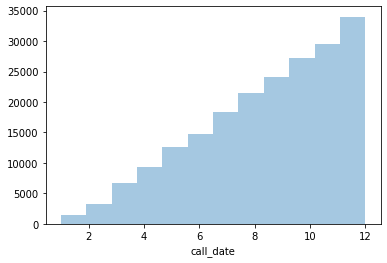

In [23]:
# всё верно, данные в пределах года.

# распределение по месяцам количества звонков
sns.distplot(calls['call_date'].dt.month, bins=12, kde=False);

Количество звонков растет от месяца к месяцу.

##### Интернет

Удаляю лишний столбец Unnamed.

Столбцы для анализа:
- испольовано мегабайт
- пользователь
- дата сессии

In [24]:
internet.drop('Unnamed: 0', axis='columns', inplace=True)

In [25]:
# просмотр статистики (числовые столбцы):

internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


Корректные данные.

In [26]:
# проверка данных за сессию, равных 0
internet.query('mb_used == 0')['mb_used'].count() * 100 / internet['mb_used'].count()

13.118155773916303

Сессий, за которые передано 0 Мб - 13%.

In [27]:
print('Первый выход в интернет:', internet['session_date'].min())
print('Последний выход в интернет:', internet['session_date'].max())

Первый выход в интернет: 2018-01-01 00:00:00
Последний выход в интернет: 2018-12-31 00:00:00


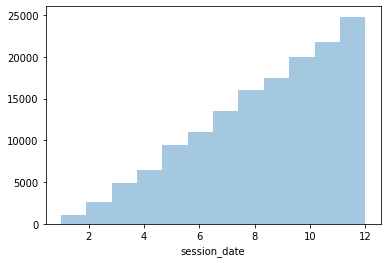

In [28]:
# всё верно, данные в пределах года.

# распределение по месяцам
sns.distplot(internet['session_date'].dt.month, bins=12, kde=False);

Количество сессий передачи данных растет от месяца к месяцу.

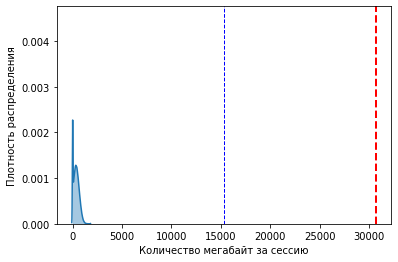

In [29]:
# график распределения и линии, обозначающие месячный лимит для тарифов
ax = sns.distplot(internet['mb_used'])
_ = ax.set(xlabel='Количество мегабайт за сессию')
_ = ax.set(ylabel='Плотность распределения')
_ = plt.axvline(15_360, color='b', linestyle='dashed', linewidth=1)
_ = plt.axvline(30_720, color='r', linestyle='dashed', linewidth=2)

Как видно, за сессию передаётся гораздо меньше данных, чем месячный лимит. Данные корректны.

##### Сообщения. 

Для анализа пригоден только столбец с датами.

In [30]:
# проверка соответствия сообщений нужному интервалу
print('Первая дата отправки сообщения в выборке:', messages['message_date'].min())
print('Последняя дата отправки сообщения в выборке:', messages['message_date'].max())

Первая дата отправки сообщения в выборке: 2018-01-02 00:00:00
Последняя дата отправки сообщения в выборке: 2018-12-31 00:00:00


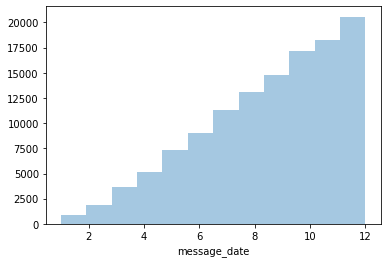

In [31]:
# корректно

# распределение по месяцам:
sns.distplot(messages['message_date'].dt.month, bins=12, kde=False);

Так же, как и для данных и звонков - практически равномерное увеличение звонков по месяцам.

In [32]:
# преобразование дат


In [33]:
display(users)
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Столбцы для анализа:
- *возраст*
- *город*
- *дата регистрации*
- *дата прекращения пользования тарифом*
- *тариф*

столбцы:
- имя
- фамилия

не использую.

In [34]:
# возраст - проверю распределение пользователей по возрастам
users['age'].value_counts().sort_index().to_frame().style.bar()

,age
18,6
19,9
20,9
21,12
22,5
23,9
24,9
25,7
26,11
27,9


Артефактов нет, возраст корректный - от 18 до 75. Учитывая, что выборка случайна и немногочисленна, разброс пользователей по возрасту в пределах нормы

In [35]:
# город
display(users['city'].unique())

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Названия городов - корректны, проблем с регистром нет.

In [36]:
# диапазон дат регистрации пользователей
print('Первая дата регистрации в выборке:', users['reg_date'].min())
print('Последняя дата регистрации в выборке:', users['reg_date'].max())

Первая дата регистрации в выборке: 2018-01-01 00:00:00
Последняя дата регистрации в выборке: 2018-12-31 00:00:00


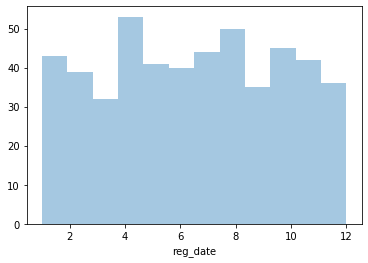

In [37]:
# Все регистрации в пределах 2018 г. 

# распределение регистраций по месяцам
sns.distplot(users['reg_date'].dt.month, bins=12, kde=False);

Нет такой же "лесенки", как для информации, передаваемой пользователями.

In [38]:
# диапазон дат отписки пользователей от тарифа
print('Первая дата отписки от тарифа:', users['churn_date'].min())
print('Последняя дата отписки от тарифа:', users['churn_date'].max())

Первая дата отписки от тарифа: 2018-08-17 00:00:00
Последняя дата отписки от тарифа: 2018-12-30 00:00:00


In [39]:
# распределение отписок по месяцам
users.query('churn_date.notna()')['churn_date'].dt.month.value_counts().sort_index().to_frame().style.bar()

,churn_date
8,2
9,3
10,9
11,8
12,16


Тоже в пределах 2018 г, аномалий не замечено.

In [40]:
# тарифы
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Артефактов нет.

#### Подготовка данных к конкретной задаче

В данной задаче принимается, что минуты и мегабайты за каждый звонок и сессию передачи данных соответственно - округляются в большую сторону.

In [41]:
# округлим длительность звонков в большую сторону, как используется в компании при подсчете задолженности
calls['duration'], calls['old_duration'] = calls['duration'].apply(math.ceil), calls['duration']

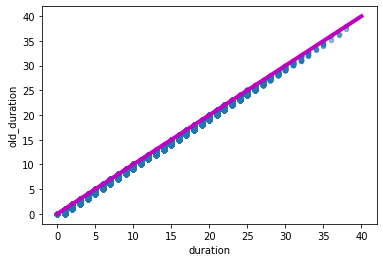

In [42]:
# график распределения исходных данных и данных после округления вверх
calls.plot(kind='scatter', x='duration', y='old_duration', alpha=0.5)
plt.plot([0, 40], [0, 40], 'm-', linewidth=4)
plt.show()

Как видно, точки, для которых старое значение превышало бы новое, отсутствуют, значит, округление вверх произведено верно.

In [43]:
# округление данных, переданных за каждый сеанс
internet['mb_used'], internet['old_mb_used'] = internet['mb_used'].apply(math.ceil), internet['mb_used']
display(internet)

,id,mb_used,session_date,user_id,old_mb_used
0,1000_0,113,2018-11-25,1000,112.95
1,1000_1,1053,2018-09-07,1000,1052.81
2,1000_2,1198,2018-06-25,1000,1197.26
3,1000_3,551,2018-08-22,1000,550.27
4,1000_4,303,2018-09-24,1000,302.56
...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,318.90
149392,1499_153,491,2018-12-14,1499,490.13
149393,1499_154,0,2018-10-27,1499,0.00
149394,1499_155,1247,2018-11-26,1499,1246.32


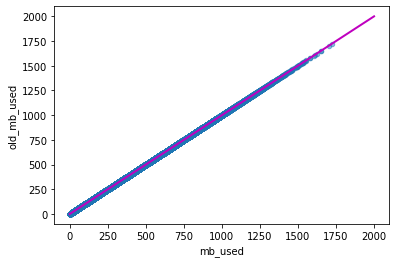

In [44]:
# график распределения исходных данных и данных после округления вверх
internet.plot(kind='scatter', x='mb_used', y='old_mb_used', alpha=0.5)
plt.plot([0, 2000], [0, 2000], 'm-', linewidth=2)
plt.show()

Данные корректны: нет значений меньше 0 (0 - неудачная сессия), максимум - 1724 мб, гораздо меньше месячного лимита.

**Вывод**: на данном этапе данные были подготовлены для дальнейшего анализа:
- исправлены данные типа "дата"
- пропуски не были обнаружены. Значения Null в столбце *churn_date* информативны и говорят о том, что тариф действующий.
- данные проанализированы на предмет артефактов. Артефакты не выявлены.

Характер данных:
- количество звонков, интернет-сессий и переданных сообщений практически равномерно растёт с каждым месяцем, что логично, т.к. в соответствии с графиком распределения регистраций пользователей их с каждым месяцем становится всё больше, а количество отписавшихся незначительно (38 человек).
- 20% звонков имеет нулевую длительность (не дозвонились)
- 13% интернет-сессий не передавали никаких данных

Эти нулевые сессии не выбиваются за пределы разумного и не будут влиять на дальнейшую статистику, т.к. информация будет суммироваться по месяцам.

Была произведена подготовка данных под конкретную задачу в соответствии с логикой работы оператора:
- для каждой сессии округлены вверх количество мегабайт
- для каждого звонка округлено вверх количество минут

### Шаг 3. Подсчет данных для каждого пользователя

Наибольший интерес представляет следующая статистика:
- количество сделанных звонков и израсходованных минут по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячная выручка с каждого пользователя

In [45]:
# создание вспомогательного словаря с датами регистраций пользователей
users_dict = users.pivot_table(index='user_id', values='reg_date', aggfunc='first').to_dict()

In [46]:
tariffs.set_index('tariff_name', inplace=True)

In [47]:
# создание словаря по параметрам тарифа, чтобы не копировать одни и те же данные в общую таблицу в каждую строку
tariff_dict = tariffs.to_dict('index')

In [48]:
calls['month'] = calls['call_date'].dt.month
calls

,id,call_date,duration,user_id,old_duration,month
0,1000_0,2018-07-25,0,1000,0.00,7
1,1000_1,2018-08-17,0,1000,0.00,8
2,1000_2,2018-06-11,3,1000,2.85,6
3,1000_3,2018-09-21,14,1000,13.80,9
4,1000_4,2018-12-15,6,1000,5.18,12
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,0.76,12
202603,1499_216,2018-10-18,19,1499,18.83,10
202604,1499_217,2018-11-10,11,1499,10.81,11
202605,1499_218,2018-10-06,5,1499,4.27,10


In [49]:
# код ревьювера
calls_1 = calls
calls_1['month'] = calls_1['call_date'].dt.month
calls_1

,id,call_date,duration,user_id,old_duration,month
0,1000_0,2018-07-25,0,1000,0.00,7
1,1000_1,2018-08-17,0,1000,0.00,8
2,1000_2,2018-06-11,3,1000,2.85,6
3,1000_3,2018-09-21,14,1000,13.80,9
4,1000_4,2018-12-15,6,1000,5.18,12
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,0.76,12
202603,1499_216,2018-10-18,19,1499,18.83,10
202604,1499_217,2018-11-10,11,1499,10.81,11
202605,1499_218,2018-10-06,5,1499,4.27,10


In [50]:
internet['month'] = internet['session_date'].dt.month
internet

,id,mb_used,session_date,user_id,old_mb_used,month
0,1000_0,113,2018-11-25,1000,112.95,11
1,1000_1,1053,2018-09-07,1000,1052.81,9
2,1000_2,1198,2018-06-25,1000,1197.26,6
3,1000_3,551,2018-08-22,1000,550.27,8
4,1000_4,303,2018-09-24,1000,302.56,9
...,...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,318.90,10
149392,1499_153,491,2018-12-14,1499,490.13,12
149393,1499_154,0,2018-10-27,1499,0.00,10
149394,1499_155,1247,2018-11-26,1499,1246.32,11


In [51]:
messages['month'] = messages['message_date'].dt.month

In [52]:
# группировка по месяцам
calls_stat = calls.pivot_table(index=['user_id','month'], values='duration', aggfunc=['sum','count'])

In [53]:
calls_stat

sum    count
              duration duration
user_id month                  
1000    5          159       22
        6          172       43
        7          340       47
        8          408       52
        9          466       58
...                ...      ...
1498    10         247       41
1499    9           70        9
        10         449       68
        11         612       74
        12         492       69

[3174 rows x 2 columns]

In [54]:
# проверка
calls.query('user_id == 1000 and month == 5')['duration'].sum()

159

In [55]:
# верно

calls.query('user_id == 1498 and month == 4')['duration'].count()

0

In [56]:
# верно

calls_stat.columns = ['total_duration', 'total_calls']

In [57]:
calls_stat

total_duration  total_calls
user_id month                             
1000    5                 159           22
        6                 172           43
        7                 340           47
        8                 408           52
        9                 466           58
...                       ...          ...
1498    10                247           41
1499    9                  70            9
        10                449           68
        11                612           74
        12                492           69

[3174 rows x 2 columns]

In [58]:
internet_stat = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc=['sum', 'count'])
internet_sample = internet_stat.sample(n=5)

In [59]:
internet_sample

,,sum,count
,,mb_used,mb_used
user_id,month,,
1353,4,5822,19
1139,11,9775,30
1123,12,17890,63
1017,9,18232,40
1025,11,14479,45


In [60]:
internet_stat.columns = ['total_mb', 'sessions']

In [61]:
# проверка
internet.query('user_id==1291 and month==3')['mb_used'].sum()

18880

In [62]:
internet.query('user_id==1288 and month == 1')['mb_used'].count()

0

In [63]:
internet_stat

total_mb  sessions
user_id month                    
1000    5          2256         5
        6         23257        49
        7         14016        29
        8         14070        29
        9         14581        27
...                 ...       ...
1498    10        20604        59
1499    9          1848         5
        10        17809        58
        11        17984        49
        12        13077        45

[3203 rows x 2 columns]

In [64]:
messages_stat = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_stat.columns = ['total_messages']
messages_stat

total_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

In [65]:
# проверка
messages_sample = messages_stat.sample(n=5)

In [66]:
messages_sample

,,total_messages
user_id,month,
1496,1,9
1239,9,29
1199,11,70
1148,11,10
1419,11,52


In [67]:
print(messages.query('user_id == 1125 and month == 1')['id'].count())
print(messages.query('user_id == 1081 and month == 8')['id'].count())

0
17


In [68]:
# верно

In [69]:
# соединение сводных таблиц с мультииндексом, внешнее соединение, важно, чтобы данные не потерялись
month_stat = calls_stat.join(messages_stat, how='outer', on=('user_id', 'month'))
month_stat = month_stat.join(internet_stat, how='outer', on=('user_id', 'month'))
# сброс мультииндекса для объединения с таблицей 'users'
month_stat = month_stat.reset_index()

In [70]:
month_stat

,user_id,month,total_duration,total_calls,total_messages,total_mb,sessions
0,1000,5,159.0,22.0,22.0,2256.0,5.0
1,1000,6,172.0,43.0,60.0,23257.0,49.0
2,1000,7,340.0,47.0,75.0,14016.0,29.0
3,1000,8,408.0,52.0,81.0,14070.0,29.0
4,1000,9,466.0,58.0,57.0,14581.0,27.0
...,...,...,...,...,...,...,...
3209,1489,9,NaN,NaN,32.0,17232.0,63.0
3210,1489,10,NaN,NaN,21.0,19588.0,63.0
3211,1489,11,NaN,NaN,20.0,17516.0,55.0
3212,1489,12,NaN,NaN,35.0,17341.0,51.0


In [71]:
month_stat = month_stat.merge(users, on='user_id', how='outer')

In [72]:
# итоговая таблица
display(month_stat)

,user_id,month,total_duration,total_calls,total_messages,total_mb,sessions,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5.0,159.0,22.0,22.0,2256.0,5.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6.0,172.0,43.0,60.0,23257.0,49.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7.0,340.0,47.0,75.0,14016.0,29.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8.0,408.0,52.0,81.0,14070.0,29.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9.0,466.0,58.0,57.0,14581.0,27.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19588.0,63.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,11.0,NaN,NaN,20.0,17516.0,55.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3213,1489,12.0,NaN,NaN,35.0,17341.0,51.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra


In [73]:
month_stat.isnull().sum()

user_id              0
month                2
total_duration      42
total_calls         42
total_messages     499
total_mb            13
sessions            13
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
dtype: int64

In [74]:
# проверка пассивных пользователей
no_messages_months = month_stat[month_stat['total_messages'].isnull()]['user_id'].value_counts()
no_messages_users_list = no_messages_months[no_messages_months > 10].index.tolist()

no_messages_users_list

[1120, 1204, 1429, 1435, 1240, 1292, 1157, 1152, 1291, 1466, 1006]

In [75]:
# проверка активности для пользователей, которые больше других не пользовались сообщениями.
activity_for_no_message_users = month_stat[['total_duration', 'total_calls', 'total_mb', 'user_id']]\
.query('user_id in @no_messages_users_list').groupby('user_id').agg('sum')
activity_for_no_message_users

,total_duration,total_calls,total_mb
user_id,,,
1006,3501.0,506.0,164395.0
1120,3257.0,444.0,116033.0
1152,3378.0,451.0,264882.0
1157,4400.0,594.0,224774.0
1204,4370.0,600.0,247152.0
1240,4145.0,572.0,376594.0
1291,6044.0,869.0,139991.0
1292,2557.0,341.0,335496.0
1429,2844.0,420.0,234356.0


Всё в порядке, сейчас есть много альтернатив смс-сообщениям, если подключён интернет.

In [76]:
# странные пропуски в месяцах
month_stat.query('month.isnull()')

,user_id,month,total_duration,total_calls,total_messages,total_mb,sessions,age,churn_date,city,first_name,last_name,reg_date,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Эти пользователи не имеют ни одного отправленного сообщения, звонка и мегабайта переданных данных. Отключились от тарифа через неделю или менее после подключения. На статистику не повлияют.

In [77]:
null_stat_columns = ['total_duration', 'total_calls', 'total_messages', 'total_mb', 'sessions']
for column in null_stat_columns:
    print('В графе ' + color.BOLD + column + color.END)
    print('Количество Null элементов:{: >7}'.format(len(month_stat.query(column + '.isnull()')[column])))
    print('Количество нулевых элементов:{: >4}'.format(len(month_stat.query(column + ' == 0')[column])))
    print()

В графе total_duration
Количество Null элементов:     42
Количество нулевых элементов:   6

В графе total_calls
Количество Null элементов:     42
Количество нулевых элементов:   0

В графе total_messages
Количество Null элементов:    499
Количество нулевых элементов:   0

В графе total_mb
Количество Null элементов:     13
Количество нулевых элементов:   2

В графе sessions
Количество Null элементов:     13
Количество нулевых элементов:   0



Null'ов значительно больше, что свидетельствует о том, что пользователи чаще не пользовались сервисами по своему желанию, нежели возникали проблемы со связью. Заменю на 0 пропущенные значения по звонкам, минутам, мегабайтам, сообщениям, т.к. они образовались после объединения таблиц внешним соединением и свидетельствуют о нулевой активности по этим параметрам за месяц.

In [78]:
month_stat['total_duration'].fillna(0, inplace=True)
month_stat['total_calls'].fillna(0, inplace=True)
month_stat['total_messages'].fillna(0, inplace=True)
month_stat['total_mb'].fillna(0, inplace=True)
month_stat['sessions'].fillna(0, inplace=True)

In [79]:
# подсчет суммы на оплату за каждый месяц для пользователей
def month_revenue(row):
# расчет коэффициента для учета абонентской платы по неполному месяцу
#     расчет превышений по тарифу
    mb_excess = row['total_mb'] - tariff_dict[row['tariff']]['mb_per_month_included']
    messages_excess = row['total_messages'] - tariff_dict[row['tariff']]['messages_included']
    minutes_excess = row['total_duration'] - tariff_dict[row['tariff']]['minutes_included']
#     функция возвращает значение расходов пользователя за месяц как сумма по тарифу + превышение
#     округляю вверх гигабайты после преобразования из мегабайт
    return tariff_dict[row['tariff']]['rub_monthly_fee'] +\
    np.ceil(max(0, mb_excess) / 1024) * tariff_dict[row['tariff']]['rub_per_gb'] +\
    max(0, messages_excess) * tariff_dict[row['tariff']]['rub_per_message'] +\
    max(0, minutes_excess) * tariff_dict[row['tariff']]['rub_per_minute']

In [80]:
month_stat['revenue'] = month_stat.apply(month_revenue, axis=1)

In [81]:
# выборочная проверка работы функции - ок

month_stat

,user_id,month,total_duration,total_calls,total_messages,total_mb,sessions,age,churn_date,city,first_name,last_name,reg_date,tariff,revenue
0,1000,5.0,159.0,22.0,22.0,2256.0,5.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23257.0,49.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14016.0,29.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14070.0,29.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,14581.0,27.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19588.0,63.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,17516.0,55.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17341.0,51.0,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,950.0
3214,1128,NaN,0.0,0.0,0.0,0.0,0.0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1950.0


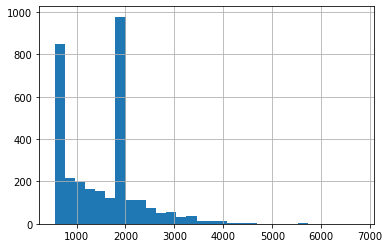

In [82]:
# отображу распределение по затратам по всем записям:
month_stat['revenue'].hist(bins=30)
plt.show()

2 пика в районе 550 и 1950 свидетельствуют о том, что эти пользователи не превышают установленных лимитов и не доплачивают в дополнение к абонентской плате.

**Вывод:** данные были усреднены по месяцам, в результате чего нулевые сессии и звонки с 0 минут перестали влиять на статистику.

Таблицы были объединены в одну, за исключением таблицы тарифов, которую удобнее было преобразовать в словарь. Я использовал внешнее соединение таблиц для того, чтобы данные не потерялись. При соединении проводились доволнительные проверки на корректность.

После группировки по месяцам так же оставались нулевые данные, но таких данных в статистике по сообщениям было на порядок больше, нежели по данным интернет-трафика и звонкам. Я проверил, что это не артефакты и что эти пользователи исправно пользовались другими видами связи.  Ситуацию с сообщениями считаю связанной с высоким распространением бесплатных интернет-мессенджеров.

Null данных было на порядок больше, чем просто нулевых, что свидетельствует о том, что пользовали чаще не пользовались сервисами по своему желанию, нежели возникали проблемы со связью. Заменил такие значения на 0, т.к. нулевая активность – тоже активность.

### Шаг 4. Анализ данных
Опишем поведение клиентов оператора, исходя из выборки.
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

In [83]:
# Усредним данные по каждому пользователю:
user_columns = ['total_duration', 'total_calls', 'total_mb', 'total_messages', 'tariff', 'revenue']
user_stat = month_stat.pivot_table(index='user_id', values=user_columns, aggfunc={'total_duration':'mean',
                                                                                 'total_calls': 'mean',
                                                                                  'total_mb':'mean',
                                                                                 'total_messages': 'mean',
                                                                                 'tariff': 'first',
                                                                                 'revenue': 'mean'})

In [84]:
user_stat.reset_index(inplace=True)

In [85]:
# группировка по тарифам
tariff_gr = user_stat.groupby('tariff')

total_duration
smart
count    351.000000
mean     418.439262
std      146.546039
min        0.000000
25%      315.958333
50%      424.875000
75%      518.616667
max      891.500000
Name: total_duration, dtype: float64

ultra
count     149.000000
mean      524.279391
std       284.142240
min         0.000000
25%       320.750000
50%       513.333333
75%       746.333333
max      1179.363636
Name: total_duration, dtype: float64



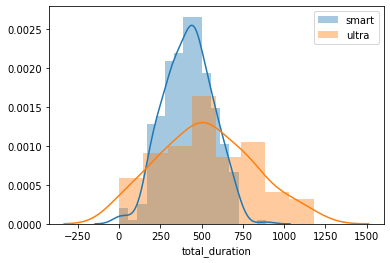

total_calls
smart
count    351.000000
mean      58.484946
std       20.305422
min        0.000000
25%       43.333333
50%       60.000000
75%       72.000000
max      121.000000
Name: total_calls, dtype: float64

ultra
count    149.000000
mean      72.945227
std       39.560997
min        0.000000
25%       44.000000
50%       72.000000
75%      102.000000
max      170.000000
Name: total_calls, dtype: float64



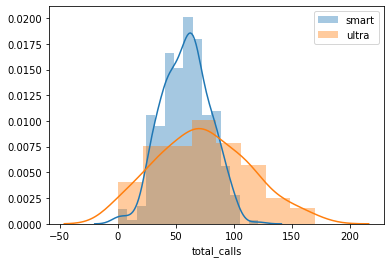

total_mb
smart
count      351.000000
mean     16155.230119
std       3681.522658
min          0.000000
25%      13882.634921
50%      16268.714286
75%      18609.027778
max      27321.000000
Name: total_mb, dtype: float64

ultra
count      149.000000
mean     19461.343437
std       8444.552074
min          0.000000
25%      13562.818182
50%      18701.600000
75%      25824.583333
max      38502.000000
Name: total_mb, dtype: float64



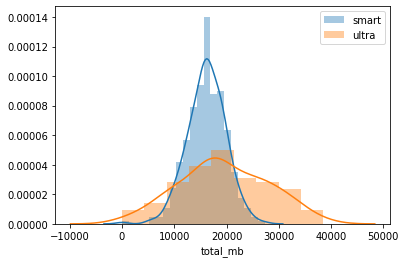

total_messages
smart
count    351.000000
mean      32.259907
std       26.530803
min        0.000000
25%       11.000000
50%       27.500000
75%       48.000000
max      118.000000
Name: total_messages, dtype: float64

ultra
count    149.000000
mean      53.668121
std       46.420854
min        0.000000
25%       14.000000
50%       45.000000
75%       84.000000
max      192.000000
Name: total_messages, dtype: float64



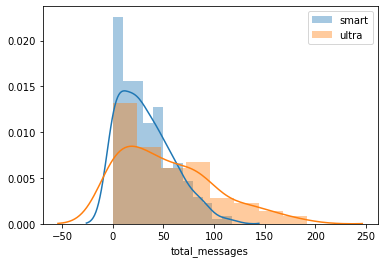

In [86]:
stat_columns = ['total_duration', 'total_calls', 'total_mb', 'total_messages']
for column in stat_columns:
    print(color.BOLD + column + color.END)
    for tariff, data in tariff_gr:
        sns.distplot(data[column], label=tariff)
        plt.legend()
        print(color.BOLD + tariff + color.END)
        print(data[column].describe())
        print()
    plt.show()

У тарифа *smart*
- среднее для длительности звонков в районе 420 минут, разброс от 0 до 730 минут. Распределение похоже на нормальное.
- среднее для количества звонков - 55-60 в месяц, разброс от 0 до 100.
- среднее для трафика - 16 гб в месяц. Большая часть пользователей использует от 5 до 25 гб.
- среднее для общего количества сообщений: 32 в месяц. распределение близко к распределению Пуассона.

Для тарифа *ultra*:
- среднее для длительности звонков 525 минут
- общее количество звонков - 70-75, разброс от 0 до 170
- общее количество переданных данных - в среднем 20 гб, от 0 до 40 Гб.
- Общее количество сообщений: в среднем 54, распределение близко к распределению Пуассона.

**Сравнение**:
- для тарифа *ultra* общая длительность звонков в среднем больше на 100 минут (+24%).
- количество звонков на 15 больше (+25%).
- трафик на 4 Гб (25%) больше
- сообщений на 22 больше (68%)

Проверим разницу в оплате:

smart , оплата:
count     351.000000
mean     1327.505056
std       607.411895
min       550.000000
25%       875.250000
50%      1176.400000
75%      1682.055556
max      4333.333333
Name: revenue, dtype: float64

ultra , оплата:
count     149.000000
mean     2086.495177
std       300.040624
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1987.500000
max      3262.500000
Name: revenue, dtype: float64



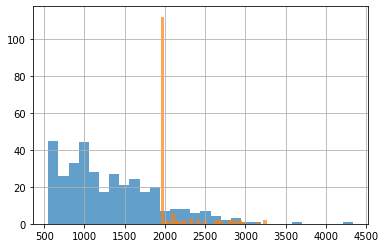

In [87]:
for tariff, data in tariff_gr:
    print(color.BOLD + tariff + color.END, ', оплата:')
    data['revenue'].hist(bins=30, alpha=0.7)
    print(data['revenue'].describe())
    print()
plt.show()

In [88]:
month_stat.query('tariff == "smart" and revenue > 550')['tariff'].count() / month_stat.query('tariff == "smart"')['tariff'].count()

0.7466367713004485

In [89]:
month_stat.query('tariff == "ultra" and revenue > 1950')['tariff'].count() / month_stat.query('tariff == "ultra"')['tariff'].count()

0.1359026369168357

Как видно, на более дорогом тарифе превышение лимита бывает очень редко - 13%, в отличие от тарифа *smart* - 76%. Следовательно, на более дорогом тарифе подавляющему большинству пользователей достаточны предоставленные квоты трафика, звонков и сообщений.

**Вывод:**

Сравнение тарифов:
- общая длительность звонков в среднем больше на 100 минут (+24%).
- количество звонков на 15 больше (+25%).
- трафик на 4 Гб (25%) больше
- сообщений на 22 больше (68%)

На более дорогом тарифе превышение по оплате очень редко (13%) против 76% у тарифа *smart*.

### Шаг 5. Проверка гипотез
- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

#### Проверка гипотезы о пользователях различных тарифов:

За нулевую гипотезу берём предположение, что данные не различаются:

- H0 - средняя выручка компании по 2-м предоставленным тарифам не различается.
- H1 - средняя выручка компании по 2-м предоставленным тарифам различается.

Т.к. есть абонентская плата как минимально возможная оплата за месяц, и этот скачок виден на графике, то данные не распределены нормально.

In [90]:
smart_stat = month_stat.query('tariff == "smart"')
ultra_stat = month_stat.query('tariff == "ultra"')

In [91]:
print('Размеры выборок: ', smart_stat.shape[0], ' и ', ultra_stat.shape[0], sep='')

Размеры выборок: 2230 и 986


Данные - количественные, и при выборке от 50-100 элементов мы можем считать, что *среднее* для выборок распределено нормально, поэтому применяем Т-критерий Стьюдента.

In [92]:
# подготовка выборок
smart_user_stat = smart_stat.pivot_table(index='user_id', values='revenue', aggfunc='mean')
ultra_user_stat = ultra_stat.pivot_table(index='user_id', values='revenue', aggfunc='mean')

In [93]:
# расчет дисперсий для выборок
print('Дисперсия для тарифа Smart: {: >10.2f}'.format(smart_user_stat['revenue'].var(ddof=1)))
print('Дисперсия для тарифа Ultra: {: >10.2f}'.format(ultra_user_stat['revenue'].var(ddof=1)))

Дисперсия для тарифа Smart:  368949.21
Дисперсия для тарифа Ultra:   90024.38


In [94]:
# дисперсии различаются в около 4 раз
# Так как данные принадлежат разным пользователям, используем метод статистики
# о равенстве среднего двух разных генеральных совокупностей по их выборкам
result = st.ttest_ind(smart_user_stat['revenue'], ultra_user_stat['revenue'], equal_var=False)

In [95]:
# стандартное значение alpha
alpha = .05

In [96]:
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Следовательно, можно утверждать, опираясь на выводы статистики, что средняя выручка по предоставленным тарифам различается.

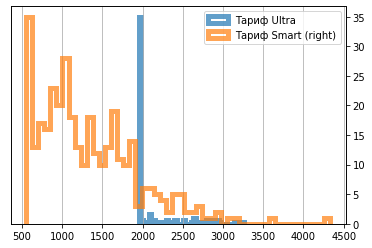

In [97]:
# графики
ax = ultra_user_stat.plot(kind='hist', bins=50, y='revenue', histtype='step', linewidth=5, alpha=0.7,
                     label='Тариф Ultra', grid=True, legend=True)
smart_user_stat.plot(kind='hist', bins=50, y='revenue', histtype='step', linewidth=5, alpha=0.7,
                     label='Тариф Smart', grid=True, legend=True, secondary_y=True, ax=ax)
plt.show()

In [98]:
if smart_user_stat['revenue'].mean() > ultra_user_stat['revenue'].mean():
    print('Тариф "Смарт" даёт больше выручки')
else:
    print('Тариф "Ультра" даёт больше выручки')

Тариф "Ультра" даёт больше выручки


##### Проверка гипотезы о том, что выручка в Москве не отличается от выручки в других городах

- H0 - средняя выручка в Москве и других городах не различается
- H1 - средняя выручка в Москве и других городах различается

In [99]:
moscow_stat = month_stat.query('city == "Москва"')
other_cities_stat = month_stat.query('city != "Москва"')

In [100]:
print('Размеры выборок: ', moscow_stat.shape[0], ' и ', other_cities_stat.shape[0], sep='')

Размеры выборок: 611 и 2605


Размеры выборок достаточны для того, чтобы считать, что среднее выборок распределено нормально и для проверки гипотез применить т-критерий Стьюдента.

In [101]:
moscow_user_stat = moscow_stat.pivot_table(index='user_id', values='revenue', aggfunc='mean')
other_cities_user_stat = other_cities_stat.pivot_table(index='user_id', values='revenue', aggfunc='mean')

In [102]:
# сравнение дисперсий
print('Дисперсия распределения для Москвы: {: >18.2f}'.format(moscow_user_stat['revenue'].var(ddof=1)))
print('Дисперсия распределения для других городов: {: >10.2f}'.format(other_cities_user_stat['revenue'].var(ddof=1)))

Дисперсия распределения для Москвы:          364839.97
Дисперсия распределения для других городов:  416629.04


In [103]:
# дисперсия различается, разница около 15%
result = st.ttest_ind(moscow_stat['revenue'], other_cities_stat['revenue'], equal_var=False)

In [104]:
if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


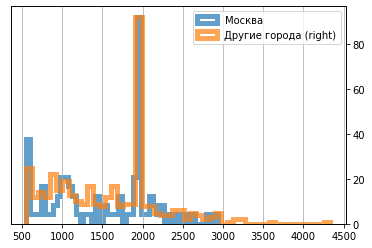

In [105]:
# графики
ax = moscow_user_stat.plot(kind='hist', bins=50, y='revenue', histtype='step', linewidth=5, alpha=0.7,
                     label='Москва', grid=True, legend=True)
other_cities_user_stat.plot(kind='hist', bins=50, y='revenue', histtype='step', linewidth=5, alpha=0.7,
                     label='Другие города', grid=True, legend=True, secondary_y=True, ax=ax)
plt.show()

Не получилось отвергнуть гипотезу, следовательно, достоверно сказать, что выручка в Москве и в других городах различается, нельзя.

**Вывод:**
- можно сказать (гипотеза о равенстве была опровергнута), что тариф **"Ультра" даёт больше** выручки,
- но **нельзя однозначно сказать** (гипотеза о равенстве выручки не была опровергнута), что **в Москве** компания на тарифах зарабатывает **больше.**

### Шаг 6. Общий вывод

**Ознакомление, предобработка:**
Для вычисления наиболее выгодного для компании тарифа пришлось произвести предобработку всех предоставленных таблиц. Выяснилось несоответствие типов дат в таблицах, исправлено.

Так же в соответствии с тарифами данные количества мегабайт и минут были округлены в большую сторону перед произведением над ними операций - в соответствии с логикой работы оператора.

Для сравнения тарифов данные сгруппированы по каждому пользователю по всем месяцам пользования тарифом с вычислением среднего.

**Параметры тарифов:**

У тарифа *smart*
- среднее для длительности звонков в районе 420 минут, разброс от 0 до 730 минут. Распределение похоже на нормальное.
- среднее для количества звонков - 55-60 в месяц, разброс от 0 до 100.
- среднее для трафика - 16 гб в месяц. Большая часть пользователей использует от 5 до 25 гб.
- среднее для общего количества сообщений: 32 в месяц. распределение близко к распределению Пуассона.

Для тарифа *ultra*:
- среднее для длительности звонков 525 минут
- общее количество звонков - 70-75, разброс от 0 до 170
- общее количество переданных данных - в среднем 20 гб, от 0 до 40 Гб.
- Общее количество сообщений: в среднем 54, распределение близко к распределению Пуассона.

**Сравнение тарифов:**
- общая длительность звонков в среднем больше на 100 минут (+24%).
- количество звонков на 15 больше (+25%).
- трафик на 4 Гб (25%) больше
- сообщений на 22 больше (68%)

На более дорогом тарифе превышение по оплате очень редко (13%) против 76% у тарифа *smart*. Следовательно, на более дорогом тарифе подавляющему большинству пользователей достаточны предоставленные квоты трафика, звонков и сообщений.

Была произведена **проверка гипотез** на равенство среднего по выборкам для:
- разных тарифов
- разных городов

В результате для тарифов гипотезу о равенстве выручки удалось отвергнуть, а для разных городов - нет.

**Итого:**
- можно сказать (гипотеза о равенстве была опровергнута), что тариф **"Ультра"** даёт **больше выручки**,
- но **нельзя** однозначно сказать (гипотеза о равенстве выручки *не была опровергнута*), что в Москве компания на тарифах зарабатывает больше, чем в других городах.